# Проект телекоммуникации

# Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Данные состоят из файлов, полученных из разных источников:

    1. contract_new.csv — информация о договоре;
    2. personal_new.csv — персональные данные клиента;
    3. internet_new.csv — информация об интернет-услугах;
    4. phone_new.csv — информация об услугах телефонии.
Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

## План работ

Для выполнения проекта необходимо предоставить следующий план действий:
    
    1. Первичное ознакомление с данными; Формирование единого датасета; Привдение данных к необходимым типам; обработка пропусков в данных; Исследовательский анализ;
    2. Подготовка признаков. Разделение на features и target, осуществить балансировку классов (SMOTE).
    3. Предобработка численных и категориальных признаков данных модели. Выбор моделей с последующей кросс-валидацией. Подбор наиболее оптимальных гиперпараметров модели. Обучение классификационных моделей, например: CatBoostRegressor, LGBMRegressor + RandomForest, DecisionTree 
    4. Анализ и интерпритация важности признаков для лучшей модели. Оценка эффективности модели на тестовой выборке.

## Импорты

In [2]:
# !pip install -U imbalanced-learn

In [3]:
# !pip install -U Boruta

In [4]:
# !pip install catboost==1.2

In [5]:
# !pip install shap
# !pip install phik

In [6]:
# Базовые библиотеки для обработки данных
import pandas as pd 
import numpy as np
# Базовые библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
# Библиотеки для корреляционного анализа
import phik
from phik import resources

# Блок преобразований из библиотеки scikit_learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif

# Метрики качества модели
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix

# Методы предобработки данных
from imblearn.over_sampling import SMOTE
from boruta import BorutaPy


from sklearn.ensemble import RandomForestClassifier
import catboost as cb
from catboost import CatBoostClassifier, Pool
import shap
pd.set_option('display.max_columns', None)

from time import time

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [7]:
RANDOM_STATE = 25092023

## 1. Ознакомление с данными

In [8]:
try:
    contract = pd.read_csv('/Users/mune_amour/Downloads/contract_new.csv')
    personal = pd.read_csv('/Users/mune_amour/Downloads/personal_new.csv')
    internet = pd.read_csv('/Users/mune_amour/Downloads/internet_new.csv')
    phone = pd.read_csv('/Users/mune_amour/Downloads/phone_new.csv')
except FileNotFoundError:
    try:
        contract = pd.read_csv('/datasets/contract_new.csv')
        personal = pd.read_csv('/datasets/personal_new.csv')
        internet = pd.read_csv('/datasets/internet_new.csv')
        phone = pd.read_csv('/datasets/phone_new.csv')
    except FileNotFoundError:
        print("Файлы не найдены ни по одному из путей")

## 1.1 Описание данных

In [9]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


В таблице contract содержатся следующие данные:

        1. customerID - айди клиента
        2. BeginDate - дата заключения договора
        3. EndDate - дата окончания действия договора (может содержать пропущенные значения, так как человек может являться абонентом на текущий момент)
        4. Type - тип подписки
        5. PaperlessBilling - электронный платежный документ
        6. PaymentMethod - способ оплаты
        7. MonthlyCharges - ежемесячный платеж по подписке
        8. TotalCharges - сколько было перечислено абонентом всего

In [10]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


В таблице personal содержатся следующие данные:

        1. customerID - айди клиента
        2. gender - дата заключения договора
        3. SeniorCitizen - является ли пенсионером
        5. Dependents - имеет ли детей

In [11]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [12]:
internet['InternetService'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

В таблице internet содержатся следующие данные:

        1. customerID - айди клиента
        2. InternetService - дата заключения договора
        3. OnlineSecurity - блокировка небезопасных сайтов 
        4. OnlineBackup - резервное копирование в режиме онлайн
        5. DeviceProtection - антивирус
        6. TechSupport - выделенная линия технической поддержки
        7. StreamingTV - стриминговое телевидение
        8. StreamingMovies - каталог фильмов

In [13]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


В таблице phone содержатся следующие данные:

        1. customerID - айди клиента
        2. MultipleLines - получает ли услуги телефонии

## 1.2 Соединение

In [14]:
data = contract.merge(personal, left_on = 'customerID', right_on = 'customerID', how = 'left')
data = data.merge(internet, left_on = 'customerID', right_on = 'customerID', how = 'left')
data = data.merge(phone, left_on = 'customerID', right_on = 'customerID', how = 'left')

In [15]:
display(data.head(3))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


## 1.3 Первичное ознакомление с данными 

In [16]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


None

Данные содержат информациб о 7043 уникальных абонентах и списке услуг, которыми они пользуются.

    1. Среди наиболее явных наблюдений, можно выделить то, что данные содержат пропуски в части списка услуг (либо телефонии, либо интернета). Причем если рассматривать пропуски с точки зрения сегментов, то можно сделать вывод о том, что пропуски однородны, то есть для интернет услуг количество пропусков аналогично по всем продуктам. Аналогичная ситуация наблюдается в сегменте телефонии. Из этого можно сделать вывод о том, что пользователи могут пользоваться не всем списком услуг сразу, а лишь определенным сегментом услуг.
    2. При просмотре типов данных, первым бросается в глаза BeginDate, EndDate, TotalCharges и senior_citizen. Необзодимо поменять тип данных для столбца BeginDate на datetime, у столбца TotalCharges необходимо поменять тип данных на float64, а столбец EndDate оставить так, как есть, поскольку он содержит данные в виде дата/"No" и служит, в основном, для выделения целевого признака, а столбец SeniorCitizen перевести в формат object, поскольку он является флагом.
    3. Также необходимо перевести названия столбцов из CamelCase в Snake_case

Заменим названия столбцов на snake_case. с попомщью созданной функции

In [17]:
def snake_case(dataframe):
    dataframe.columns = dataframe.columns.str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True).str.lower()

In [18]:
snake_case(data)
print(data.columns)

Index(['customer_i_d', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_t_v', 'streaming_movies', 'multiple_lines'],
      dtype='object')


Поменяем типы данных, для корректного отрображения

In [19]:
# Изменения типа для begin_date
data['begin_date'] = pd.to_datetime(data['begin_date'])

# Изменения типа для total_charges
data.loc[data['total_charges'] == ' ', 'total_charges'] = 0 
data['total_charges'] = data['total_charges'].astype('float64')

# Изменения типа для total_charges
data['senior_citizen'] = data['senior_citizen'].astype('object')

In [20]:
display(data.describe())

,monthly_charges,total_charges
count,7043.000000,7043.000000
mean,64.761692,2115.312885
std,30.090047,2112.742814
min,18.250000,0.000000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


    1. Данные столбца monthly_charges имеют довольно таки низкий разброс, что логично, поскольку стоимость подписки рассчитывается исходя из количества подключенных услуг (скорее всего так)
    2. данные в столбце total_charges имеют более высокий разброс, что может быть вызвано, в первую очередь с тем, что итоговая сумма будет зависеть напрямую от времени, которое провел абонент будучи пользователем услуг компании.

## 1.4 Вывод по первому пункту

В ходе первичного ознакомления с данными были проделаны следующие действия: 

    1. Описаны поля данных, с которыми необходимо будет работать
    2. Исходные данные были объеденены в единый датасет, содержаший полный перечень полей для моделирования
    3. Заменены типы данныз для столбцов begin_date, seior_citizen, total_charges на необходимые для дальнейшей работы
    4. столбцы переведены в формат snake_case
    5. Первично проанализированы численные столбцы total_charges и total_charges

## 2. EDA

## 2.1 Обработка пропущенных значений 

In [21]:
data.isna().sum()

customer_i_d            0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_t_v        1526
streaming_movies     1526
multiple_lines        682
dtype: int64

In [22]:
data['internet_service'] = data['internet_service'].fillna('NotUsed')

In [23]:
data['multiple_lines'] = data['multiple_lines'].fillna('NotUsed')

data[['online_security', 'online_backup', 
      'device_protection', 'tech_support', 
      'streaming_t_v', 'streaming_movies']] = data[['online_security', 'online_backup', 
                                                  'device_protection', 'tech_support', 
                                                  'streaming_t_v', 'streaming_movies']].fillna('NotUsed')

В ходе заполнения пропусков были заполнены пропуски в следующих столбцах: 

        1. В столбце internet_service пропущенные щначения заполнены на 'Unknown', поскольку эта информация не может быть получена логически
        2. В столбце multiple_lines пропущенные значения заменены на 'No', поскольку пользователи могут не пользоваться услугами связи
        3. В столбцах 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies' пропущенные значения были заполнены на 'No', поскольку пользователи могут пользоваться только услугами связи, без учета интернет услуг. 

## 2.2 Визуализация данных

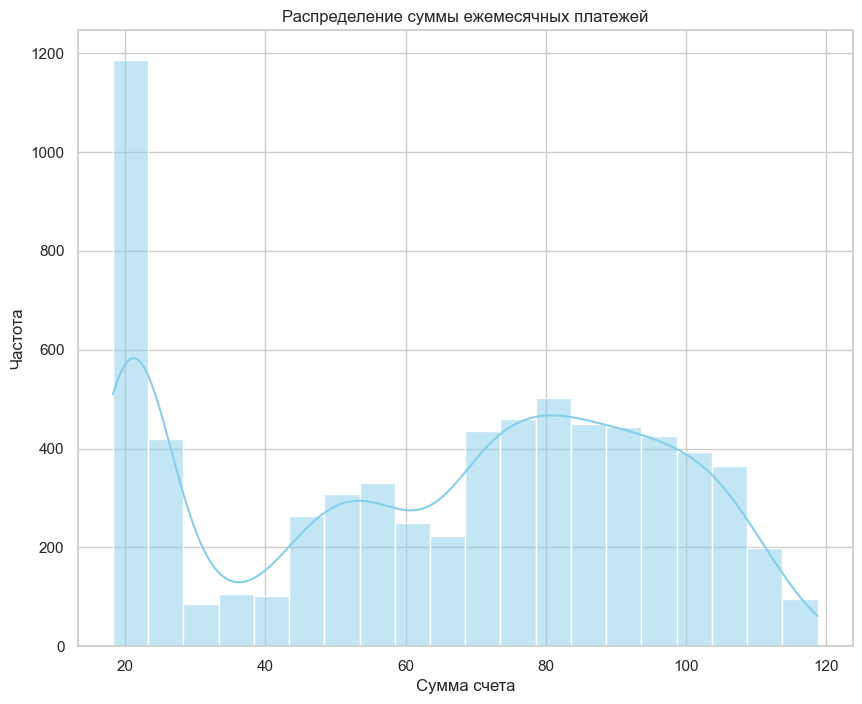

In [24]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8)) 

sns.histplot(data["monthly_charges"], bins=20, kde=True, color="skyblue")
plt.title("Распределение суммы ежемесячных платежей")
plt.xlabel("Сумма счета")
plt.ylabel("Частота")
plt.show()

Для удобства буду говорить, что цены приведены в долларах


На основе гистограммы можно сделать вывод о том, что наибольшая часть распределения ежемесячных платежей находится в диапазоне от 70 до 110 долларов, однако слишком сильно выделяется пласт данных, содержащих стоимость подписки в 0-30 долларов, возможно это дисконтные предложения клиентам, необходим дальнейший анализ

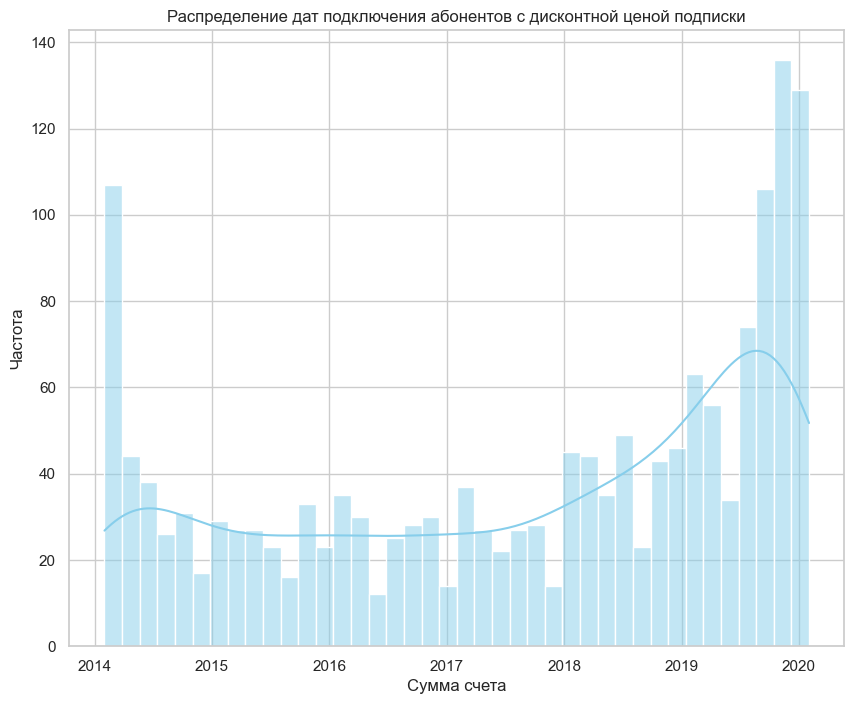

In [25]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8)) 

sns.histplot(data["begin_date"][data['monthly_charges'] <= 30], bins=40, kde=True, color="skyblue")
plt.title("Распределение дат подключения абонентов с дисконтной ценой подписки")
plt.xlabel("Сумма счета")
plt.ylabel("Частота")
plt.show()

Если отобрать значения до 30 долларов включительно, и сделать гистограмму по распределению подключений, то можно сделать вывод о том, что ближе к 2020 году компания нарастила абонентов благодаря дисконтным подпискам на свои услуги. Для дальнейшей аналитики необзодимо выявить среди каких сегментов пользователей произошло наращивание абонентской базы 

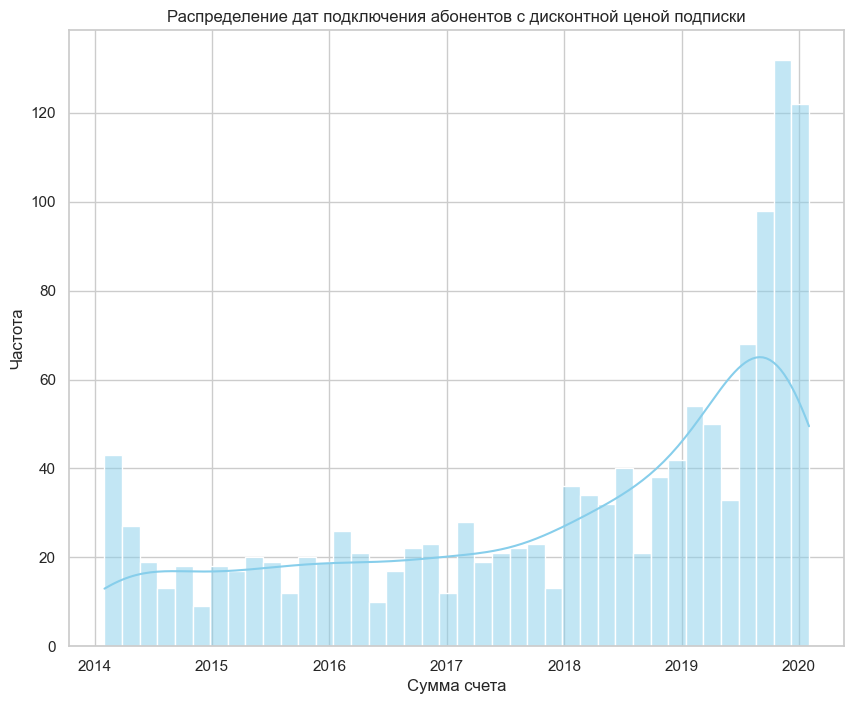

In [26]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8)) 

sns.histplot(data["begin_date"][(data['monthly_charges'] <= 30) & (data['multiple_lines'] != 'Yes') & (data['internet_service'] != 'Unknown')], bins=40, kde=True, color="skyblue")
plt.title("Распределение дат подключения абонентов с дисконтной ценой подписки")
plt.xlabel("Сумма счета")
plt.ylabel("Частота")
plt.show()

Таким образом можно сделать вывод о том, что наибольшее количество абонентов, пришедших на площадку по дисконтной стоимости подписки является сегмент интернет услуг в период с 2019 по 2020 год.

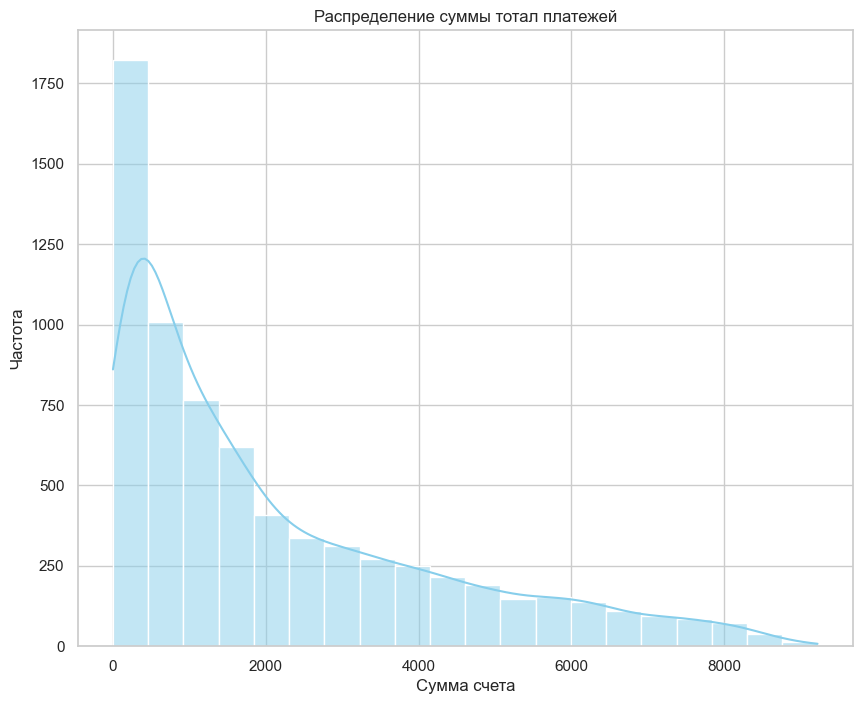

In [27]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8)) 

sns.histplot(data["total_charges"], bins=20, kde=True, color="skyblue")
plt.title("Распределение суммы тотал платежей")
plt.xlabel("Сумма счета")
plt.ylabel("Частота")
plt.show()

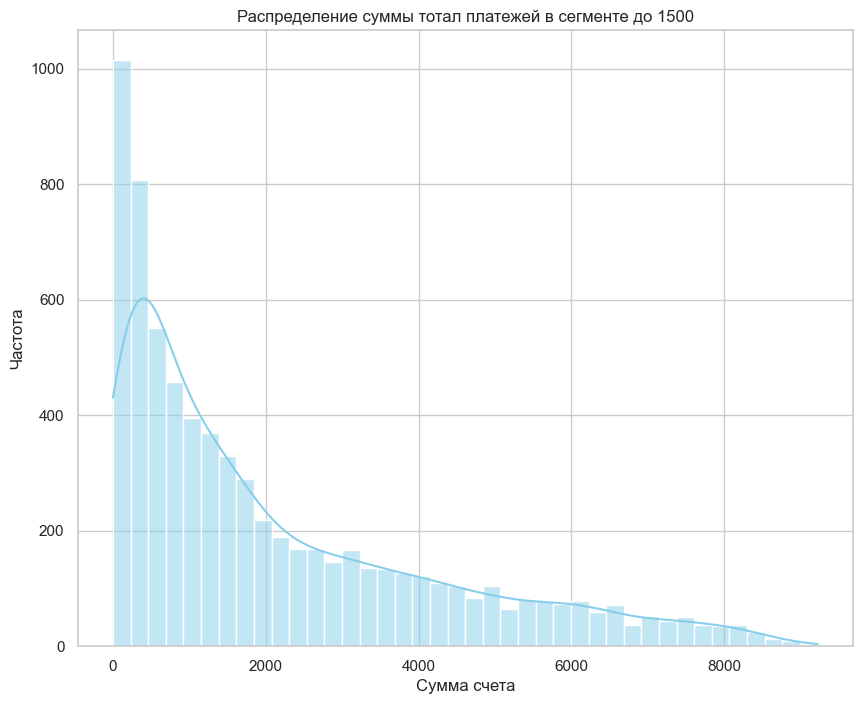

In [28]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 8)) 

sns.histplot(data["total_charges"], bins=40, kde=True, color="skyblue")
plt.title("Распределение суммы тотал платежей в сегменте до 1500")
plt.xlabel("Сумма счета")
plt.ylabel("Частота")
plt.show()

Данные распределены экспоненциально, также можно наблюдать явно выбивающиеся пики в диапазоне от 0 до 500 долларов, что логично увязывается с предыдущими выводами о том, что компания реализовала акцию по дисконту на ежемесячные платежи и нарастила абонентскую базу, которая не успела принести компании достаточное количество денег.

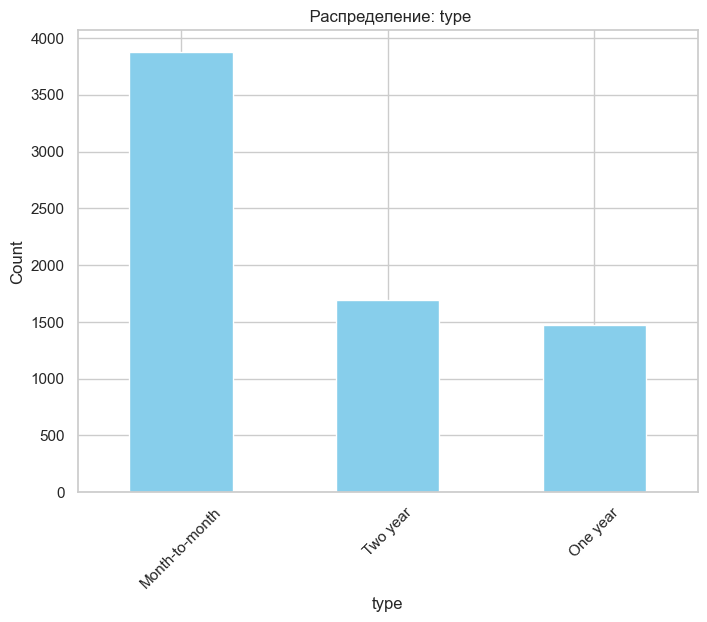

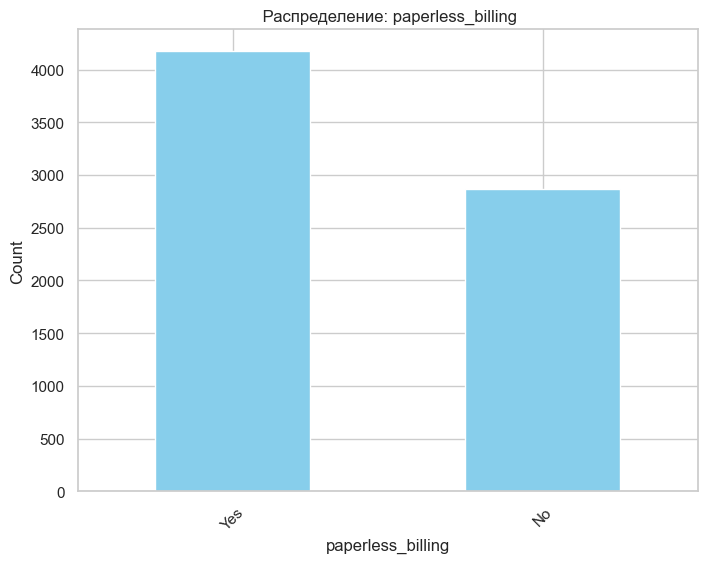

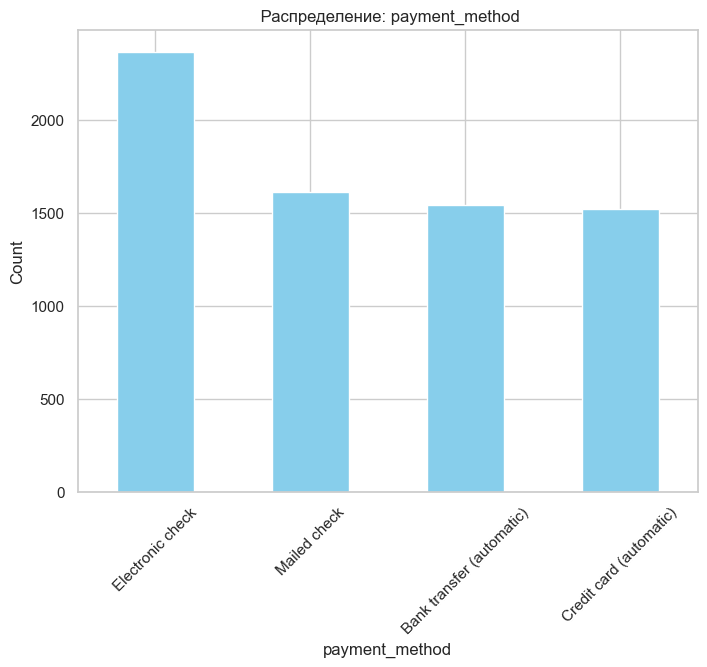

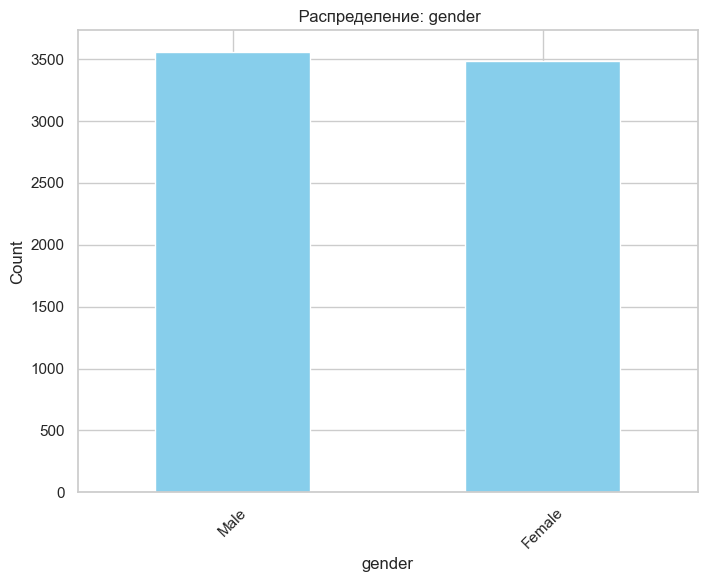

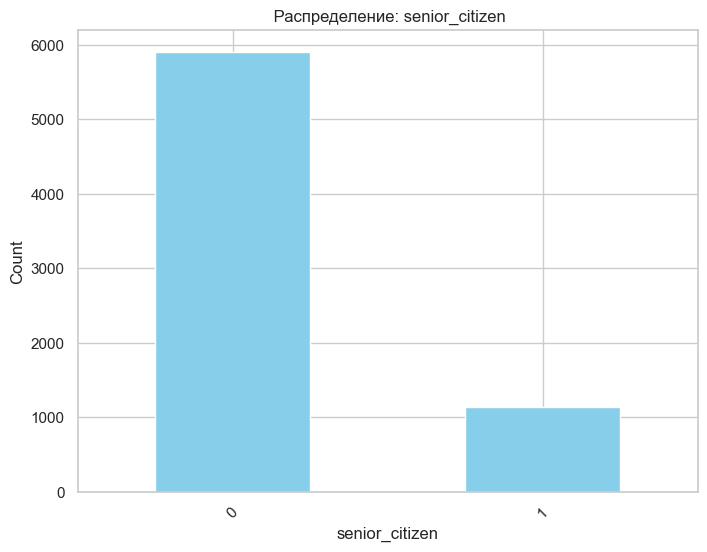

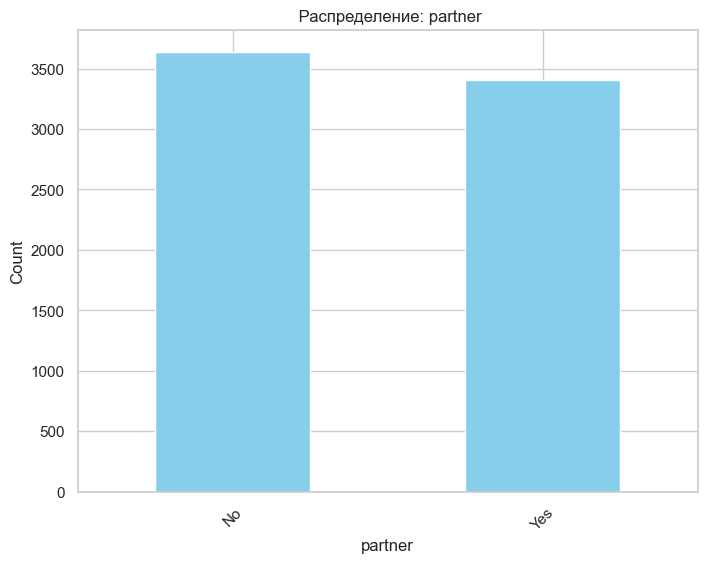

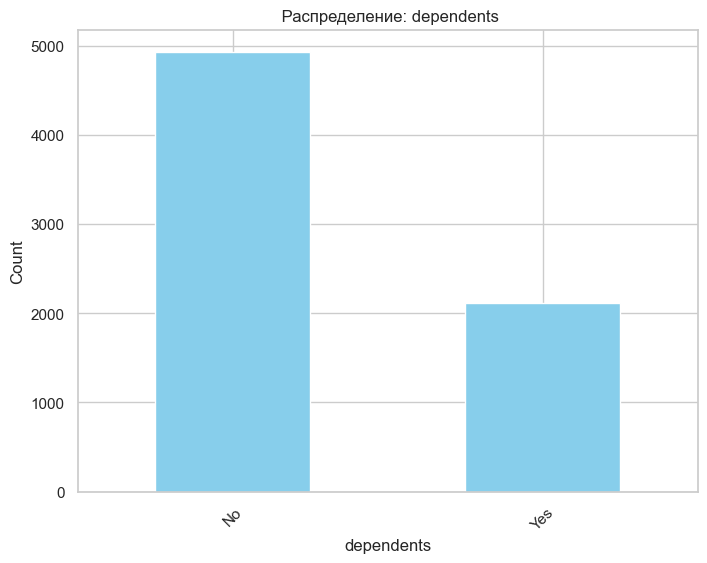

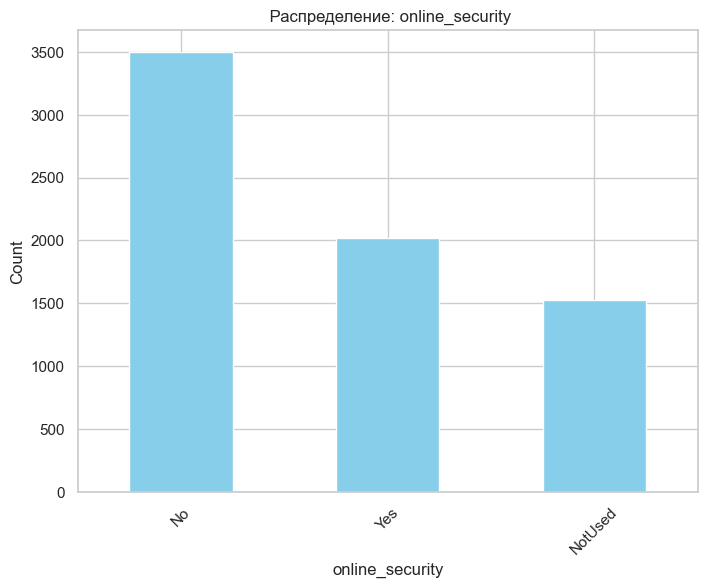

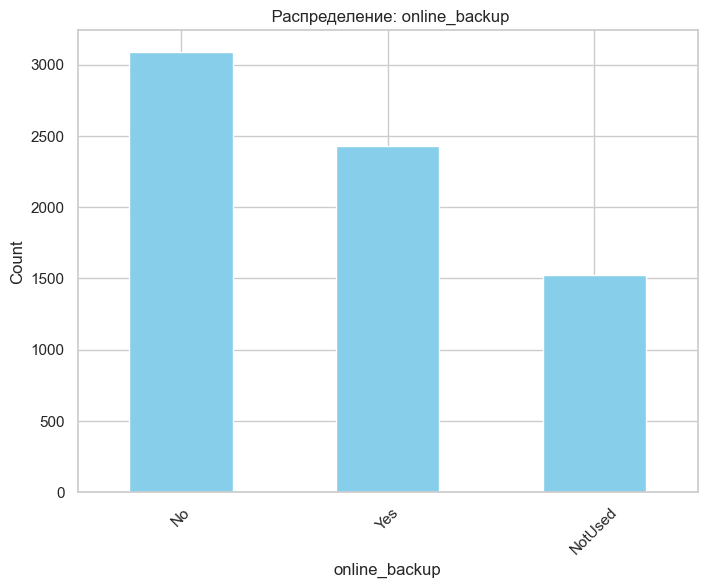

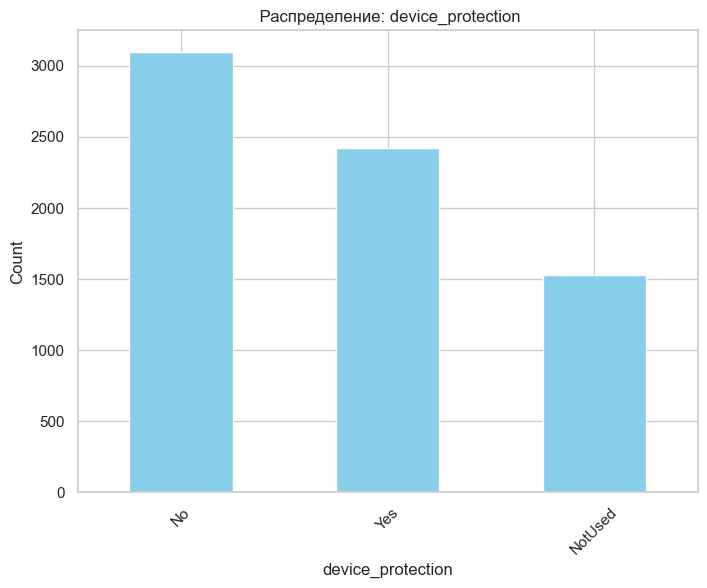

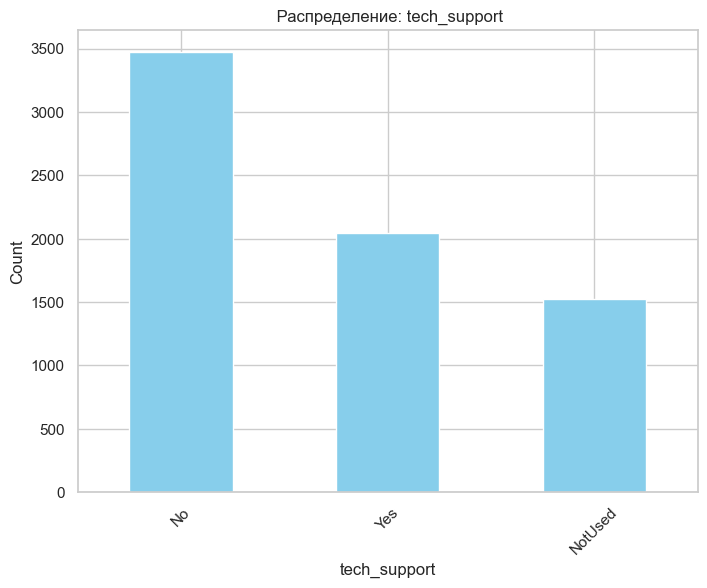

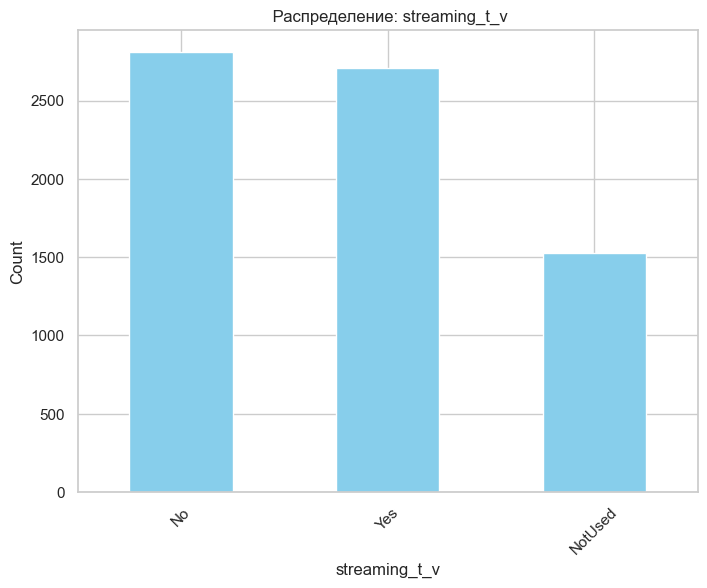

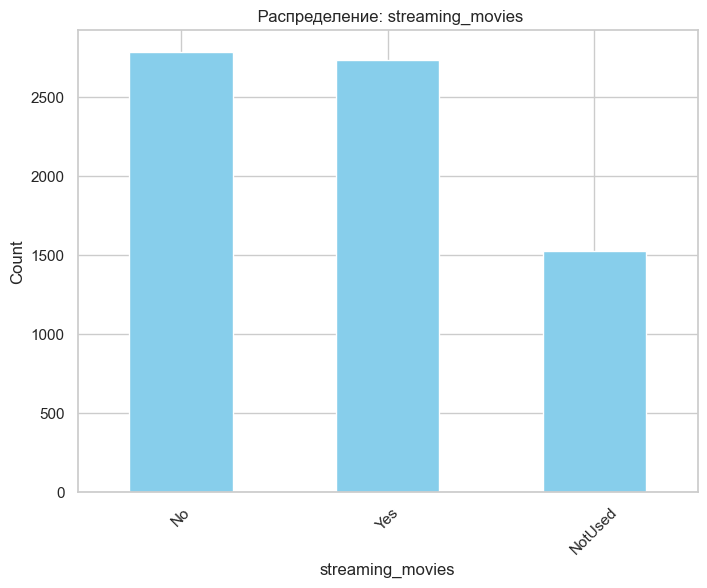

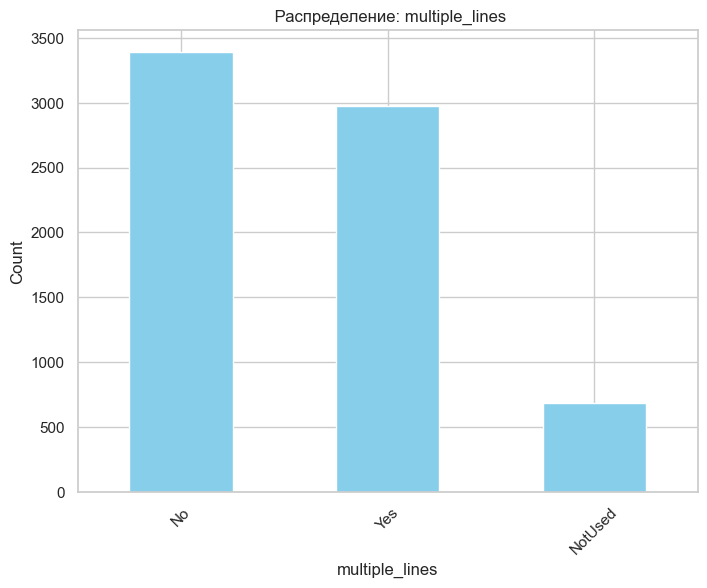

In [29]:
# Зададим список категориальных фичей
cat_features = ['type','paperless_billing','payment_method','gender','senior_citizen',
                'partner','dependents','online_security','online_backup','device_protection',
                'tech_support', 'streaming_t_v','streaming_movies','multiple_lines']

for feature in cat_features:
    plt.figure(figsize=(8, 6))  
    data[feature].value_counts().plot(kind='bar', color='skyblue') 
    plt.title(f' Распределение: {feature}')  
    plt.xlabel(feature)  
    plt.ylabel('Count')  
    plt.xticks(rotation=45)
    plt.show() 

**Вывод: **
    
    1. Наибольшее количество пользователей вносит ежемесячные платежи, однако реже встречаются двухлетние и однолетие подписки
    2. Большая часть клиентов пользуется электронным платежным документов 
    3. В столбце payment_method наиболее выражен кластер пользователей, оплачивающих подписку с помощтб электронного чека
    4. В столбце пол абоненты равномерно распределены между собой
    5. В столбце senior_citizen великовозрастные пользователи соотносятся как 1 к 5 (на одного пенсионера призодится 5 не пенсионеров)
    6. В столбце partner почти равномерно распределены одинокие и семейные люди, что логично, учитывая то, что как минимум на одного одинокого пользователя приходится сразу 2 человека, выступающих как один пользователь
    7. Наибольшая часть пользователей не имеет детей
    8. В сегменте интернет услуг наиболее ярковыражена услуга тв и фильмотеки (эти услуги имеют почти равное количество подключений, относительно тех, кто их не использует). Самой наименее популярной услугой является тех поддержка и онлайн секьюрити (ими пользуются в среднем в 36% случаев среди подключивших интернет услуги)
    9. услугой multiple_lines пользуется 48% пользователей телефонии

Выделим целевую переменную

In [30]:
data['is_left'] = 0

data.loc[data['end_date'] != 'No', 'is_left'] = 1
data.loc[data['end_date'] == 'No', 'is_left'] = 0

In [31]:
ratio = data['is_left'].value_counts()[0]/data['is_left'].value_counts()[1]
display(data['is_left'].value_counts())
print('Соотношение классов целевой переменной:', round(ratio, 1))

0    5942
1    1101
Name: is_left, dtype: int64

Соотношение классов целевой переменной: 5.4


Целевая переменная имеет сильный дизбаланс. Соотношение положительного класса к отрицательному составляет 5к1, или проще говоря 80/20

## 2.3 Вывод по пункту EDA

Во втором пункте было выполнено: 

    1. Обработаны пропуски
    2. Осуществлена визуализация данных и последующая аналитика данных
    3. Выделен целевой прищнак, подсчитано соотношение классов

## 3. Моделирование

## 3.1 Обогащение данных и корреляционный анализ

Обогатим наши данные признаком sub_duration, который будет рассчитываться на основе разницы между датой конца действия договора и датой начала действия договора, а в случаях когда такой даты нет (если абонент действующий), то будем вычитать из даты 1 февраля 2020 года (именно на эту дату исследование является актуальным) дату начала действия договора

Таким образом мы сформируем классы пользователей, разделив их на полугодовые интервалы

In [32]:
# Выделим последнюю имеющуюся дату на основе предоставленной информации
reference_date = pd.to_datetime('2020-02-01')


data['end_date'].loc[data['end_date'] == 'No'] = np.nan

# Переведем данные в соответствующий формат
data['end_date'] = pd.to_datetime(data['end_date'])
data['begin_date'] = pd.to_datetime(data['begin_date'])


data['sub_duration'] = data['end_date'] - data['begin_date']
data['sub_duration'] = data['sub_duration'].dt.days
data.loc[data['end_date'].isna(), 'sub_duration'] = (reference_date - data['begin_date']).dt.days


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [33]:
# def define_interval(duration):
#     if duration <= 180:
#         return 'half_year_sub'
#     elif 180 < duration <= 365:
#         return 'one_year_sub'
#     elif 365 < duration <= 545:
#         return 'one_with_half_year_sub'
#     elif 545 < duration <= 730:
#         return 'two_year_sub'
#     elif 730 < duration <= 910:
#         return 'two_with_half_year_sub'
#     elif 910 < duration <= 1095:
#         return 'three_year_sub'
#     else:
#         return 'more_than_three_year_sub'

In [34]:
data['sub_duration'] = data['sub_duration'].astype('float64')

Создадим корреляционную матрицу с помощью библиотке phik, которая позволяет анализировать взаимрсвязи, в том числе, категориальных переменных на основе хи-квадрат статистики

In [35]:
data = data.drop(columns = ['customer_i_d', 'begin_date', 'end_date'], axis = 1)

In [36]:
phik_matrix = data.phik_matrix(interval_cols = ['monthly_charges', 'total_charges', 'sub_duration'])

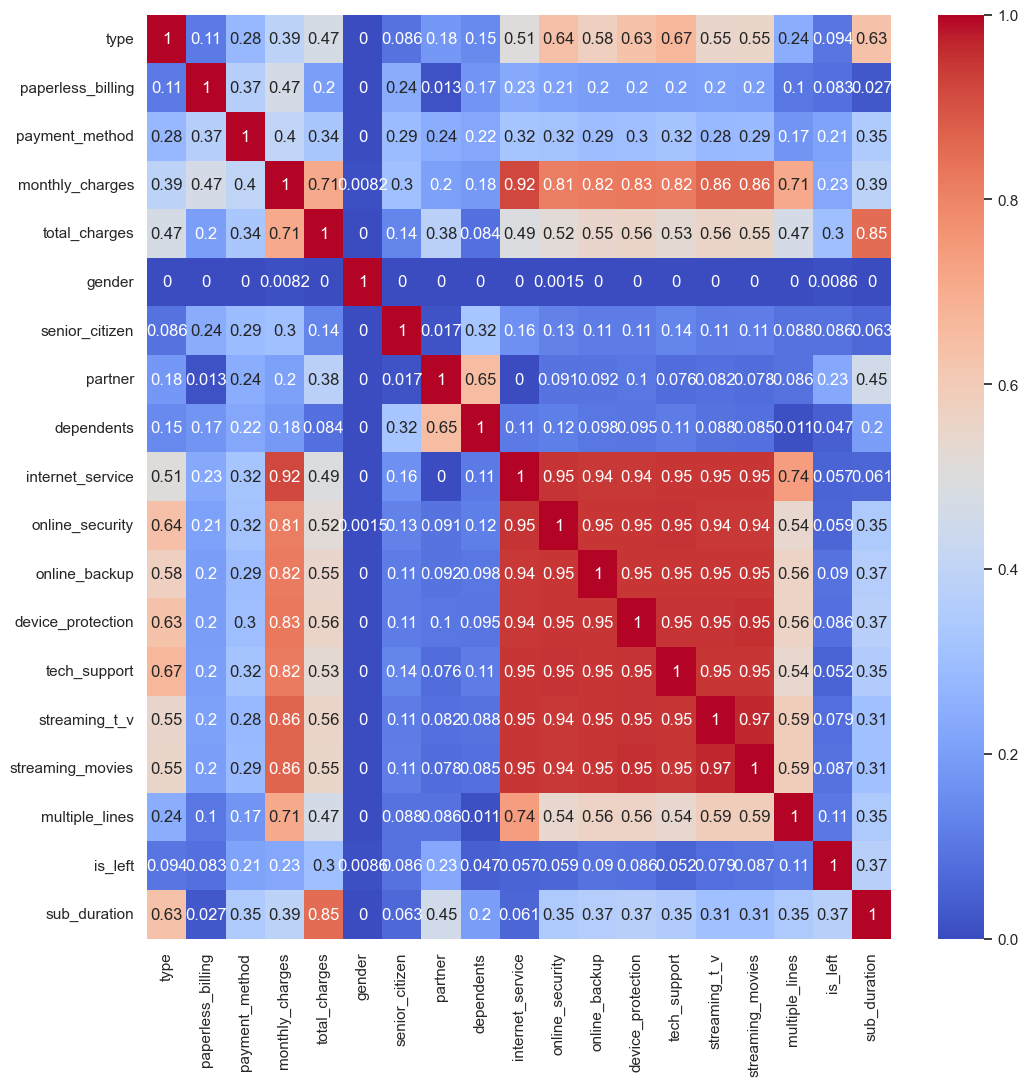

In [37]:
plt.figure(figsize = (12,12))
sns.heatmap(phik_matrix, cmap = 'coolwarm', annot = True)
plt.show()

Вывод: 

    1. 'total_charges' и 'monthly_charges' имеют высокую корреляцию (0.711), что логично, поскольку одно напрямую зависит от другого.

    2. 'is_left' и 'sub_duration' имеют коэффициент корреляции (0.33), что свидетельствует о наличии связи между сроком жизни клиента и оттоком клиента (чем больше срок жизни клиента, тем выше вероятность оттока)

    3. Переменные, характеризующие услуги интернета ('internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies') и имеют крайне высокие коэффициенты корреляции друг с другом, что ожидаемо, так как интернет услуги, обычно, подключаются в виде пакета услуг.

    4. На столбец 'is_left' наибольшее влияние имеют следующие переменные: sub_duration, total_charges, partner, monthly_charges, payment_method, multiple_lines. 

 ## 3.2 Финальная предобработка данных

Сформируем обучающие фичи и целевую переменную. Разделим данные на обучающую, валидационную и тестовую выборки по соотношению 3к1

In [38]:
# Разделение данных на обучающую, валидационную и тестовые выборки
features_train, features_test, target_train, target_test = train_test_split(data.drop('is_left', axis=1), data['is_left'], test_size=0.25, random_state=RANDOM_STATE, stratify=data['is_left'] )

print('Размер обучающей выборки: ', features_train.shape)
print('Размер тестовой выборки: ', features_test.shape)

Размер обучающей выборки:  (5282, 18)
Размер тестовой выборки:  (1761, 18)


In [39]:
list_ = [target_train, target_test]
for target in list_:
    print(target.value_counts()[0]/target.value_counts()[1])

5.394673123486683
5.403636363636363


Сформируем пайплайн, включающий следующие этапы: 

    1. Стандартизация числовых переменных
    2. Кодируем категориальные переменные
    3. Обучаем трансформеры на обучающей выборке и впоследствии применяем обученный транформер к валидационной и тестовой выборке, чтобы избежать утечек данных.

## 3.2.1 Пайплайны для предобработки и семплирования данных 

### Пайплайн предобработки данных (StsndartScaller, OrdinalEncoder)

In [40]:
# Определение численных и категориальных признаков
numeric_features = features_train.select_dtypes(include=['float64']).columns
categorical_features = features_train.select_dtypes(include=['object']).columns

# Создание пайплайна
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])

# Составление преобразователя признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
# Создание пайплайна для предобработки
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Применяем предобработку к обучающей, валидационной и тестовой выборкам
features_train_preprocessed = preprocessing_pipeline.fit_transform(features_train)
features_test_preprocessed = preprocessing_pipeline.transform(features_test)

Вывод: 
    Данные предобработаны и готовы к обучению.

## 3.2.2 Ресемплинг (SMOTE)

In [41]:
# Пайплайн для балансировки и кросс-валидации модели
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
model = CatBoostClassifier(random_state=RANDOM_STATE, eval_metric='AUC', verbose=0)

pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=RANDOM_STATE)),
    ('classifier', model)
])

scores = cross_val_score(pipeline, features_train_preprocessed, target_train, cv=cv, scoring='roc_auc')

print("Средняя оценка AUC на кросс-валидации с учетом SMOTE:", scores.mean())

Средняя оценка AUC на кросс-валидации с учетом SMOTE: 0.8646475930317805


## 3.2.3 Отбор фичей (BorutaPy)

Преобразуем массивы в DataFrame для интерпритации результатов

In [42]:
all_column_names = numeric_features.tolist() + categorical_features.tolist()
features_train_preprocessed = pd.DataFrame(features_train_preprocessed, columns=all_column_names)
features_test_preprocessed = pd.DataFrame(features_test_preprocessed, columns=all_column_names)

##  3.3 Моделирование

## 3.3.1 CatBoostClassifier

In [43]:
pool = Pool(data = features_train_preprocessed, label = target_train)
cb = CatBoostClassifier(
                         random_state = RANDOM_STATE,
                         eval_metric = 'AUC', 
                         metric_period = 50,
                         od_type = 'IncToDec',
                         od_wait = 20,
                         verbose = 0)
grid = {
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128],
    'random_strength': [0.1, 0.5, 1.0],
}
result = cb.grid_search(grid, pool, plot = True, cv=5, partition_random_seed=RANDOM_STATE)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8141626859
bestIteration = 100

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8141627	best: 0.8141627 (0)	total: 5.09s	remaining: 2m 12s

bestTest = 0.8144419027
bestIteration = 150

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8144419	best: 0.8144419 (1)	total: 9.89s	remaining: 2m 3s

bestTest = 0.8152560048
bestIteration = 50

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8152560	best: 0.8152560 (2)	total: 14.7s	remaining: 1m 57s

bestTest = 0.8150205208
bestIteration = 100

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8150205	best: 0.8152560 (2)	total: 19.5s	remaining: 1m 52s

b

In [44]:
print('Best parameters: {}\n'.format(result['params']))

Best parameters: {'border_count': 128, 'l2_leaf_reg': 1, 'random_strength': 1.0}



Гиперпараметры подобраны. Приступим к обучению модели

In [45]:
model = CatBoostClassifier(
                        verbose = False, 
                        random_seed = RANDOM_STATE,
                        border_count = 128, 
                        l2_leaf_reg = 1,
                        leaf_estimation_method = 'Newton',
                        random_strength = 1.0
                        )
scores_cb = cross_val_score(model, features_train_preprocessed, target_train, cv=5, scoring='roc_auc')

print("Средняя оценка AUC на кросс-валидации с учетом SMOTE:", scores_cb.mean())

Средняя оценка AUC на кросс-валидации с учетом SMOTE: 0.8855188638769327


Для модели подобраны гиперпараметры и и ее результаты оценены на кросс-валидации

In [46]:
train_pool = Pool(data = features_train_preprocessed, label = target_train)

In [47]:
start = time()
cb = CatBoostClassifier(
                        eval_metric = 'AUC',
                        random_seed = RANDOM_STATE,
                        iterations = 700, 
                        border_count = 128, 
                        l2_leaf_reg = 1,
                        leaf_estimation_method = 'Newton',
                        random_strength = 0.5,
                        metric_period = 50,
                        od_type = 'IncToDec',
                        od_wait = 15
                        )

cb.fit(train_pool,
      verbose = True,
      plot = True)
print('Модель импортирована: {}'. format(cb.is_fitted()))
print('Параметры модели:\n{}'. format(cb.get_all_params()))

end = time()
cb_time = (end-start)/60
print(round(cb_time, 3))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	total: 1.59ms	remaining: 1.11s
50:	total: 61.8ms	remaining: 786ms
100:	total: 123ms	remaining: 731ms
150:	total: 186ms	remaining: 678ms
200:	total: 248ms	remaining: 616ms
250:	total: 311ms	remaining: 557ms
300:	total: 373ms	remaining: 494ms
350:	total: 436ms	remaining: 434ms
400:	total: 502ms	remaining: 374ms
450:	total: 567ms	remaining: 313ms
500:	total: 631ms	remaining: 251ms
550:	total: 693ms	remaining: 187ms
600:	total: 756ms	remaining: 124ms
650:	total: 818ms	remaining: 61.5ms
699:	total: 880ms	remaining: 0us
Модель импортирована: True
Параметры модели:
{'nan_mode': 'Min', 'eval_metric': 'AUC', 'iterations': 700, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'od_pval': 0, 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'eval_fraction': 0, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 1, 'random_s

## 3.3.2 RandomForestClassifier

### GridSearch

In [48]:
grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5, 10]
}

print('# Настройка гиперпараметров для AUC')
print()
rf = RandomForestClassifier(random_state=RANDOM_STATE)

clf = GridSearchCV(rf, grid, scoring='roc_auc')
clf.fit(features_train_preprocessed, target_train)

best_rf_model = clf.best_estimator_

print("Лучшие параметры, найденные на этапе обучения:")
print(clf.best_params_)

cv_rf = clf.best_score_.mean()
# Оценка лучшей модели на кросс-валидации
print("Оценка лучшей модели на кросс-валидации (ROC AUC):", cv_rf)

# Настройка гиперпараметров для AUC

Лучшие параметры, найденные на этапе обучения:
{'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
Оценка лучшей модели на кросс-валидации (ROC AUC): 0.8206481272972104


In [49]:
start = time()

rf = RandomForestClassifier(
                            random_state = RANDOM_STATE,
                            max_depth = 10, 
                            min_samples_split = 10, 
                            n_estimators = 300)

rf.fit(features_train_preprocessed, target_train)

end = time()
rf_time = (end-start)/60
print(round(rf_time, 3))

0.015


## 3.4 Оценка моделей (РАЗДЕЛ ПЕРЕНЕСЕН ИЗ 3.4 В 4)

# 4. Отчет о проделанной работе

### 4.1-4.3 Ключевые шаги при работе над проектом + анализ соответствия запланированной работе сделанным шагам + краткое описание предобработки данных

Знаком " + " выделены шаги, которые были выполнены, в соответствии с планом работ.

При работе над проектом были выделены 2 основных этапа: 
    
1. Исследовательский анализ данных

На данном этапе были произведены следующие действия: 

    1. Импортированы и соеденены данные, проведено первичное ознакомление с признаками (+);
    2. Предобработаны пропуски в данных. (+);
        a) total_charges - заменили пробелы на 0
        б) при соединении данных появились пропуски в сегменте интернет услуг и телефонии (заменены на NotUsed)
    3. Проанализированы численные признаки. Зафиксированы основные тенденции (наблюдается резкий прирост абонентской базы в 2019-2020 году по дисконтной месячной ставке) (+);
    4. Проанализированы дискретные признаки. (наиболее популярной услугой в сфере интернета является тв и онлайн кинотеатр, наименее популярной является онлайн секьюрити. Услугами связи пользуется примерно половина пользователей) (+);

2. Моделирование

На этапе моделирования были осуществлены следующие действия: 

    1. Выделена целевая переменная "is_left". Исследован дисбаланс классов в целевой переменной (85% действующих абонентов на 15% оттекших) (+);
    2. Данные обогащены признаком "sub_duration", который рассчитывается на основе вычитания даты оттока клиента и датой заключения договора (для действующих клиентов производится вычитание из последней имеющейся даты: 2020-02-01) (+);
    3. Проведен корреляционный анализ данных, данные исследованы на мультиколлинеарность. Исследована зависимость между данными и целевой переменной (+);
    4. Произведена дополнительная предобработка данных, посредством кодирования категориальных переменных и стандартизации численных признаков (сформирован пайплайн предобработки) (+);
    5. В скоуп взяты 2 модели: CatBoostClassifier и RandomForestClassifier, подобраны гиперпараметры и проведена оценка моделей на кросс-валидации. Составлена сравнительная таблица с результатами для выбранных моделей (+);
    6. Проведено тестирование наилучшей модели (CatBoostClassifier). Выведены наиболее важные признаки, а также продемонстрирована степень влияния каждого признака на результат предсказания модели (+);

### 4.4 Итоговый список признаков

Итоговая таблица для моделирования признаков имеет следующий вид:

        1. gender - дата заключения договора (преобразован с помощью OrdinalEncoder)
        2. senior_citizen - является ли пенсионером (преобразован в формат object) (преобразован с помощью OrdinalEncoder)
        3. dependents - имеет ли детей (преобразован с помощью OrdinalEncoder)
        4. internet_service - дата заключения договора (преобразован с помощью OrdinalEncoder)
        5. online_security - блокировка небезопасных сайтов (преобразован с помощью OrdinalEncoder)
        6. online_backup - резервное копирование в режиме онлайн (преобразован с помощью OrdinalEncoder)
        7. device_protection - антивирус (преобразован с помощью OrdinalEncoder)
        8. tech_support - выделенная линия технической поддержки (преобразован с помощью OrdinalEncoder)
        9. streaming_t_v - стриминговое телевидение (преобразован с помощью OrdinalEncoder)
        10. streaming_movies - каталог фильмов (преобразован с помощью OrdinalEncoder)
        11. multiple_lines - получает ли услуги телефонии (преобразован с помощью OrdinalEncoder)
        12. type - тип подписки (преобразован с помощью OrdinalEncoder)
        13. paperless_billing - электронный платежный документ (преобразован с помощью OrdinalEncoder)
        14. payment_method - способ оплаты (преобразован с помощью OrdinalEncoder)
        15. monthly_charges - ежемесячный платеж по подписке (признак стандартизован с помощью StandartScaler)
        16. total_charges - сколько было уплачено абонентом всего (признак стандартизован с помощью StandartScaler)
        17. sub_duration - длительность проживания абонента на платформе (рассчитывается на основе вычитания даты оттока клиента и датой заключения договора (для действующих клиентов производится вычитание из последней имеющейся даты: 2020-02-01) (признак стандартизован с помощью StandartScaler)
        18. is_left - статус клиента (рассчитывается на основе наличия или отсутствия записи в столбце end_date)

### 4.5 Рефлексия над сложностями и путями их решения.

1. Первая сложность заключалась в том, чтобы правильно определить длительность лайфтайма пользователя, поскольку необходимо было выбрать дату, согласно которой бы рассчитывалась длительность лайфтайма для активных пользователей. 

Решение - было принято решение брать последнюю актуальную дату, на которую проводится исследование: 1 февраля 2020 года


2. Вторая сложность заключалась в построении правильного пайплайна преобразований, который не создавал бы утечек данных

Решение - терпение ревьюера и множество материала, просмотренного с целью понять как они делаются


3. Третья сложность заключалась в том, чтобы правильно определить тех пользователей, которые не пользовались одним из 2 базовых сегментов услуг (изначально помечались как не используемые, что неправильно)

Решение - данные по пользователям, которые не пользовались одним из сегментов услуг заменены на 'NotUsed'


4. Не сразу заметил, что столбец total_charges вместо нулевых значений имеет пробелы " "

Решение - как только заметил, так сразу поправил...


5. Самая главная сложность была в подписи осей Х и У в графике waterfall. Поскольку наивным присвоением это проблема не решалась, необходимо было искать работающую альтернативу

Решение - подсказка ревьюера! Оси проставлены.

### 4.6 Итоговая таблица со сравнением результатов моделей: 

In [50]:
relult_info = [
        ['CatBoostClassifier', scores_cb.mean(), cb_time],
        ['RandomForestClassifier', cv_rf, rf_time]
       ]
final_result = pd.DataFrame(relult_info, columns=['Модель', 'CrossValScore', 'Время обучения (мин)'])
final_result.round(3)

,Модель,CrossValScore,Время обучения (мин)
0,CatBoostClassifier,0.886,0.015
1,RandomForestClassifier,0.821,0.015


Вывод:

    При сравнении моделей CatBoostClassifier и RandomForestClassifier нижнюю планку по метрике ROC-AUC прошла модель CatBoost со средним значением метрики AUC-ROC в 0.88, также выиграв и по времени обучения (на 0.001 минуты). 

Приступим к финальному тесту модели на тестовой выборке и последующему анализу модели.

### 4.7 Лучшая модель, обзор

Лучшая модель: 
    
        1. CatBoostClassifier 
        2. Гиперпараметры: 'border_count': 128, 'l2_leaf_reg': 1, 'random_strength': 1.0 (для просмотра всех гиперпараметров раскомментировать код ниже)
        3. Результат на кросс-валидации AUC-ROC: 0.886

In [51]:
# print('Параметры модели:\n{}'. format(cb.get_all_params()))

### 4.8 Рассчет итогой метрики AUC-ROC  и ACCURACY

In [52]:
# Рассчитываем AUC-ROC
cb_pred_proba = cb.predict_proba(features_test_preprocessed)[:, 1]
cb_roc_auc = roc_auc_score(target_test, cb_pred_proba)

# Рассчитываем точность (Accuracy)
cb_pred = cb.predict(features_test_preprocessed)
cb_accuracy = accuracy_score(target_test, cb_pred)

print(f'AUC-ROC: {cb_roc_auc:.4f}')
print(f'Accuracy: {cb_accuracy:.4f}')

AUC-ROC: 0.9073
Accuracy: 0.9018


Модель сохраняет обобщающие способности и на независимом тесте, не потеряв в оценке по метрике AUC-ROC (0.9073). 

При этом точность модели составляет 0.9018 на тесте, что означает долю правильно классифицированных образцов (инстансов) среди всех образцов в наборе данных. 

При этом значение метрики AUC-ROC равное 0.9086 означает, что модель показывает отношение между чувствительностью (Правильно предсказанный отток клиента) и специфичностью (Правильно предсказанное сохранение пользователя на платформе) модели при различных порогах классификации.

### 4.8.1 Визуализация ROC кривой

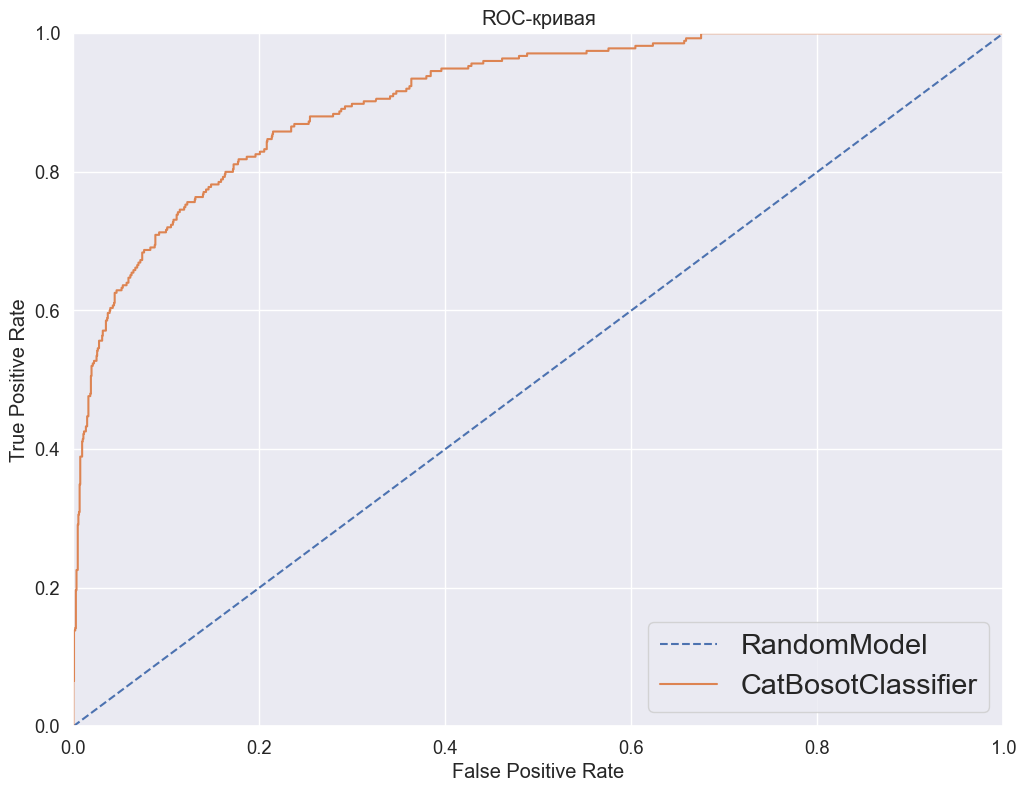

In [66]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


#CatBosotClassifier
fpr, tpr, thresholds = roc_curve(target_test, cb_pred_proba)
auc_roc = roc_auc_score(target_test, cb_pred_proba)
plt.plot(fpr, tpr, label='CatBosotClassifier')

# #RandomForestClassifier
# fpr, tpr, thresholds = roc_curve(target_test, rf_pred_proba)
# auc_roc_downsampled = roc_auc_score(target_test, rf_pred_proba)
# plt.plot(fpr, tpr, label='RandomForestClassifier')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

Вывод: 
    
    На данном графике наглядно продемонстрированы оценки AUC-ROC для моделей CatBoostClassifier. Исходя из анализа графика можно сделать вывод о том, что модель CatBoost имеет более высокую площадь под кривой, относительно оценок модели со случайным выбором отнесения пользователя к тому или иному классу, что подтверждает адекватность модели  

### 4.9 Интерпритация матрицы ошибок

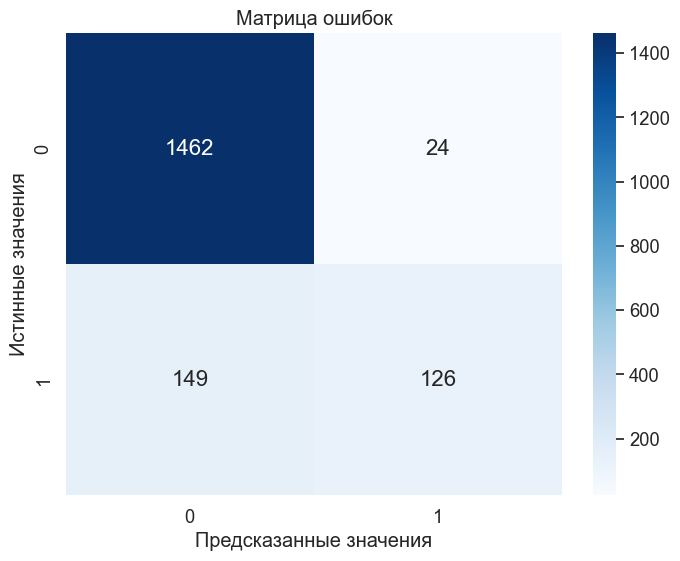

In [53]:
confusion = confusion_matrix(target_test, cb_pred)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2) 
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})

plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок')

plt.show()

**Вывод:**

    Классификатор верно определил 126 случаев, когда произошел отток пользователя с платформы, и 1462 случая сохранения пользователя на платформе. В предсказании поведения клиента модель допустила 24 ошибки в определении ложноположительных результатов (когда клиент должен оттечь с платформы) и 149 ложноотрицательных результатов (абонент продолжал быть клиентом платформы, однако модель не идентифицировала его как оттекшего с платформы).

### 4.10 Оценка важности признаков

In [54]:
feat_imp = cb.get_feature_importance(prettified = True)
feat_imp

,Feature Id,Importances
0,sub_duration,40.238224
1,total_charges,8.925493
2,monthly_charges,8.897346
3,type,8.560377
4,payment_method,5.628541
5,multiple_lines,4.062897
6,partner,3.985724
7,online_backup,2.750230
8,device_protection,2.539502
9,dependents,2.340404


Для обеих моделей, в первой пятерке показателей важности при принятии решения, являются: 
sub_duration, total_charges, monthly_charges, type, payment_method. 

Для более точного анализа важности признаков (с определением того в какую сторону тот или иной показатель влияет на обобщение целевой переменной) необходим дальнейший анализ. 

### 4.10.1 Анализ принятия решений модели с помощью коэффициента Шелли

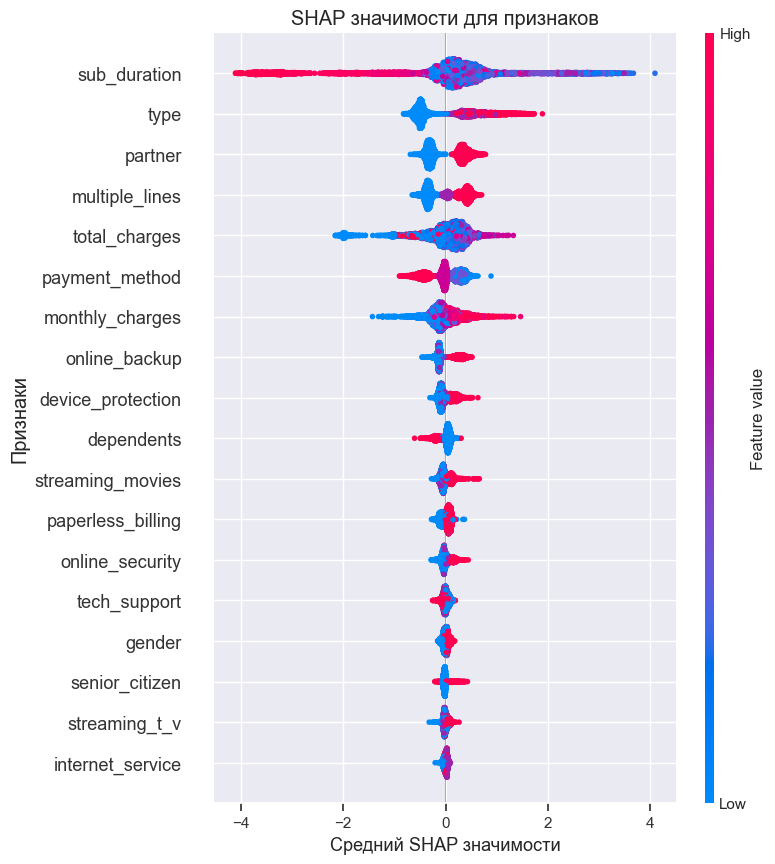

In [94]:
# Создаем объект Explainer для модели
explainer = shap.Explainer(cb)

shap_values = explainer.shap_values(features_train_preprocessed)


fig, ax = plt.subplots(figsize=(14, 10))

shap.summary_plot(shap_values, features_train_preprocessed, show = False)

ax.set_xlabel("Средний SHAP значимости")  # Подпись оси X
ax.set_ylabel("Признаки")  # Подпись оси Y справа

plt.title("SHAP значимости для признаков")

plt.show()

На основе оценки важности признаков моделирования можно сложить портрет типичного пользователя, который собирается оттечь с платформы:
    
    1. Его нахождение на платформе составлет небольшой промежуток времени (закономерна и невысокая месячная цена подписки)
    2. Абонент скорее всего подписан на месячной основе
    3. Абонент одинок
    4. Абонент не пользуется услугами сотовой связи
Для абонента, не планирующего оттечь с платформы ситуация будет противоположной 

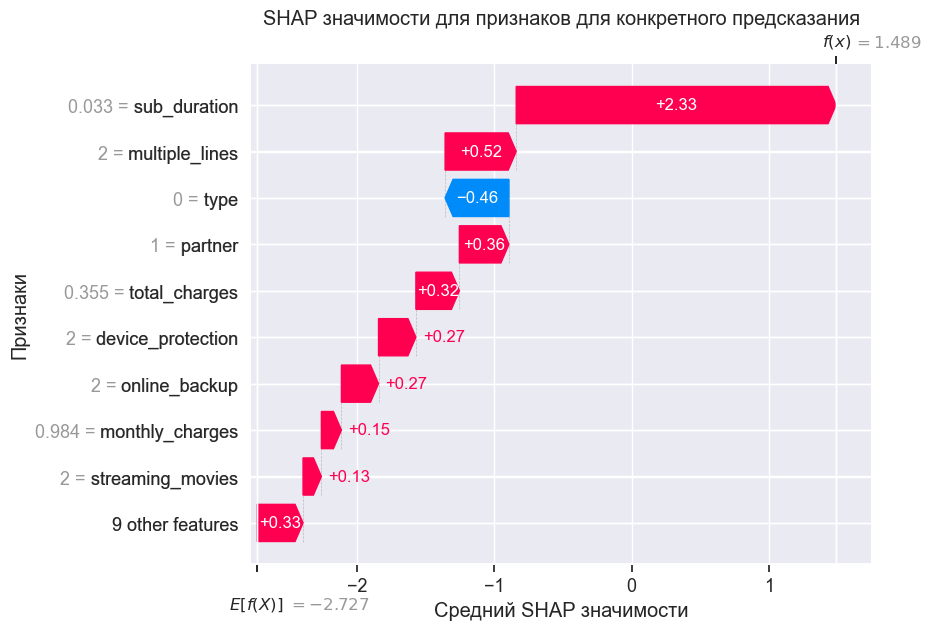

In [93]:
explainer = shap.Explainer(cb)
shap_values = explainer(features_train_preprocessed)

fig, ax = plt.subplots(figsize=(14, 10))

shap.plots.waterfall(shap_values[3], show=False)

ax.set_xlabel("Средний SHAP значимости")  # Подпись оси X
ax.set_ylabel("Признаки")  # Подпись оси Y справа

plt.title("SHAP значимости для признаков для конкретного предсказания")

plt.show()

При рассмотрении конкретного предсказания, гипотеза о портрете абонента, не планирующего оттечь с платформы, подтверждается. 